In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline 

Purpose: Investigate if there is any difference in gene expression between fly females and males for different tissues.

To investigate this I will extract gene expression data from a database called FlyAtlas2 (http://flyatlas.gla.ac.uk/FlyAtlas2/index.html?page=gene). Gene concentration is reported in the database as FPKM units. We can assume that a higher FPKM value mean higer gene expression for a given gene. It is generally accepted that higer gene expression will be translaed into a higer protein concentration for the protein coded by the gene.

First thing I need to do is get the data. One way to do this is by getting a list of all genes. Then use that list of genes to get expression data for females and males flies for different tissues by doing web scrapping.

All the expression data is stored in a MySQL database. From the database I managed to get a list of all the genes, but not the expression data.

In [2]:
#reading gene table copied from FlyAtlas2 MySQL database
gene_table = open('gene_table_fly_stlas_2.txt', 'r') 
read_gene_table = gene_table.read()
gene_table.close()

In [3]:
splitted_gene_table = read_gene_table.split(',') #table was a long single string. Split it by ','
splitted_gene_table[:10]

["('FBgn0000003'",
 "'CR32864'",
 "'7SLRNA:CR32864'",
 "'Signal recognition particle 7SL RNA CR32864'",
 'NULL',
 'NULL',
 "'chr3R:6822497-6822796'",
 "'ncRNA')",
 "('FBgn0000008'",
 "'CG6741'"]

In [4]:
#a CG name or annotation symbol is a unique ID name given to a gene. Lets make an empty list to store all the genes' IDs
cg_list=[]

#append annotation symbol (CG ID) to a list. CR IDs will be eliminated as they don't code proteins.
for item in iter(splitted_gene_table) : #iterate over list and append string that start with CG
    if item[1:3]=='CG' :
        cg_list.append(item)

cg_list[:10]

["'CG6741'",
 "'CG10325'",
 "'CG11648'",
 "'CG4032'",
 "'CG6093'",
 "'CG3796'",
 "'CG17907'",
 "'CG9151'",
 "'CG7899'",
 "'CG5610'"]

In [5]:
#each annotation symbol is inside "''". It is like a string inside a string. Lets get rid of a pair of ''
cg_list_splitted = [item.split("'", 2) for item in cg_list] 
cgname_list = [item[1] for item in cg_list_splitted]
cgname_list = list(set(cgname_list)) #drop duplicates

cgname_list[:10]

['CG31950',
 'CG32556',
 'CG9334',
 'CG8562',
 'CG9072',
 'CG1652',
 'CG43925',
 'CG33144',
 'CG44174',
 'CG7990']

In [6]:
import time

adult_FPKM_df = pd.DataFrame()
#Extracting FPKM data and appending it to adult_FPKM_df.
t0 = time.time() #for the sake of knowing how long it'll take to get the data
for cgname in cgname_list :
    
    #I had to wrap the loop in a try/except because not all genes in cgname_list have a data table in the web.
    #This throws an error because table is not found.
    
    try :
        data = pd.read_html('http://flyatlas.gla.ac.uk/FlyAtlas2/index.html?search=gene&gene='+str(cgname)+'&idtype=cgnum#mobileTargetG', index_col=0)
        adult_FPKM_df = adult_FPKM_df.append({'Annotation Symbol':cgname,
                                              #Malpighian Tubule FPKM for female
                                              'MTube_fem':data[0][3][9], 
                                              #Malpighian Tubule FPKM for male
                                              'MTube_male': data[0][1][9], 
                                              #Brain FPKM for female
                                              'Brain_female': data[0][3][4], 
                                              #Brain FPKM for male
                                              'Brain_male': data[0][1][4],
                                              #Eye FPKM for female
                                              'Eye_female': data[0][3][3], 
                                              #Eye FPKM for male
                                              'Eye_male': data[0][1][3],
                                              #Salivary gland FPKM for female
                                              'SGland_female': data[0][3][11], 
                                              #Salivary gland FPKM for male
                                              'SGland_male': data[0][1][11], 
                                              #Carcass FPKM for female
                                              'Carcass_female': data[0][3][19],
                                              #Carcass FPKM for male
                                              'Carcass_male': data[0][1][19]}, 
                                             ignore_index=True)
    except ValueError :
        print (cgname)
        pass

t1 = time.time() #for the sake of knowing how long it took to get the data
print(t1-t0)

CG42303
CG9865
CG42306
CG42384
CG17767
CG45075
CG42630
CG30080
CG34315
CG30100
CG30072
CG42385
CG17139
CG44194
CG45099
CG17867
CG9960
CG42557
CG42517
CG42496
CG42502
CG3240
CG42373
CG13175
CG42379
CG15386
CG33650
CG11566
CG45065
CG17344
CG45093
CG42456
CG17197
CG33786
CG44890
CG42386
CG34177
CG17725
CG43776
CG7869
CG42505
CG45068
CG42634
CG42497
CG42511
CG34317
CG42503
CG30481
CG42488
CG42730
CG42740
CG42769
CG32298
CG45092
CG18749
CG33935
CG43439
CG42726
CG42381
CG45088
CG42245
CG43816
CG42487
CG43201
CG1410
CG2128
CG42375
CG42660
CG7964
CG42363
CG42498
8938.959909439087


-Script took about 2.5 hours to run.

-In total I extracted data from 13,835 genes. The data for the other 71 genes in the list 
(13,906 {# of genes in cg_list} - 13835 {# of genes data was collected in adult_FPKM_df}) was not collected because those genes encode the same proteins as other genes which data is under another gene ID (cgname aka Annotation Symbol).

In [7]:
adult_FPKM_df.to_csv('adult_fem_male_FPKM.csv', sep=',', index=False)

In [8]:
adult_FPKM_df_data = pd.read_csv('adult_fem_male_FPKM.csv', sep=',')
adult_FPKM_df_data.head()

,Annotation Symbol,Brain_female,Brain_male,Carcass_female,Carcass_male,Eye_female,Eye_male,MTube_fem,MTube_male,SGland_female,SGland_male
0,CG31950,2.9 ± 0.5,3.0 ± 0.6,4.1 ± 1.3,3.9 ± 0.5,3.9 ± 0.1,4.3 ± 0.3,7.6 ± 4.1,4.4 ± 2.8,4.9 ± 0.8,6.6 ± 0.7
1,CG32556,0.8 ± 0.1,0.6 ± 0.0,4.0 ± 0.9,3.6 ± 0.4,9.1 ± 0.2,15 ± 3.7,0.9 ± 0.2,1.1 ± 0.2,16 ± 2.8,27 ± 2.1
2,CG9334,0.1 ± 0.2,0.5 ± 0.5,0.0 ± 0.0,43 ± 22,0.0 ± 0.0,0.1 ± 0.0,0.0 ± 0.0,1.9 ± 1.9,0.0 ± 0.0,2.4 ± 1.8
3,CG8562,0.0 ± 0.0,0.0 ± 0.0,0.2 ± 0.3,3.6 ± 1.8,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,1.6 ± 1.3,0.3 ± 0.1,0.1 ± 0.1
4,CG9072,4.9 ± 1.1,5.7 ± 0.4,0.1 ± 0.1,1.2 ± 0.7,3.4 ± 0.5,4.4 ± 1.4,0.6 ± 0.1,1.0 ± 1.2,0.1 ± 0.1,0.4 ± 0.1


-Data points were extracted with standard deviation. So each column needs to be splitted to separate avg from SD.

In [9]:
adult_FPKM_df_splitted = pd.DataFrame()

for i, row in adult_FPKM_df_data.iterrows() :
    adult_FPKM_df_splitted = adult_FPKM_df_splitted.append(row.str.split(' ').str[0]) #taking advantage of the .str.split()method

adult_FPKM_df_splitted.head()

,Annotation Symbol,Brain_female,Brain_male,Carcass_female,Carcass_male,Eye_female,Eye_male,MTube_fem,MTube_male,SGland_female,SGland_male
0,CG31950,2.9,3.0,4.1,3.9,3.9,4.3,7.6,4.4,4.9,6.6
1,CG32556,0.8,0.6,4.0,3.6,9.1,15,0.9,1.1,16,27
2,CG9334,0.1,0.5,0.0,43,0.0,0.1,0.0,1.9,0.0,2.4
3,CG8562,0.0,0.0,0.2,3.6,0.0,0.0,0.0,1.6,0.3,0.1
4,CG9072,4.9,5.7,0.1,1.2,3.4,4.4,0.6,1.0,0.1,0.4


In [10]:
(adult_FPKM_df_splitted).dtypes

Annotation Symbol    object
Brain_female         object
Brain_male           object
Carcass_female       object
Carcass_male         object
Eye_female           object
Eye_male             object
MTube_fem            object
MTube_male           object
SGland_female        object
SGland_male          object
dtype: object

I need to change the data to float. But, I know that some of the extracted values have 'N.A.' as a value. Indicating that data for that point doesn't exist. See below as an example.

In [11]:
adult_FPKM_df_splitted[adult_FPKM_df_splitted['MTube_fem'] == 'N.A.']

,Annotation Symbol,Brain_female,Brain_male,Carcass_female,Carcass_male,Eye_female,Eye_male,MTube_fem,MTube_male,SGland_female,SGland_male
8564,CG42768,20,23,N.A.,26,33,33,N.A.,57,17,25
10982,CG11901,42,32,N.A.,N.A.,278,129,N.A.,178,192,N.A.
13703,CG12008,1.7,1.5,16,18,21,32,N.A.,30,18,31


Since this data is missing and I can not use inputation methods such as mean or median to estimate those values (nothing tells me that an estimated value for the missing data is == to the mean of other expressed genes), I will replace those 'N.A.' values using np.nan

In [12]:
adult_FPKM_df_splitted.replace('N.A.', np.nan, inplace=True)

In [13]:
adult_FPKM_df_splitted.isnull().sum()

Annotation Symbol    0
Brain_female         2
Brain_male           5
Carcass_female       2
Carcass_male         1
Eye_female           5
Eye_male             6
MTube_fem            3
MTube_male           0
SGland_female        6
SGland_male          4
dtype: int64

I'm glad to see there are not so many nan values. That means that I have usable data for most of the genes that I extracted.
Now that I changed the invalid values to nan, lets change the dtypes to float to all numerical data.

In [14]:
adult_FPKM_df_splitted[['Brain_female',
                        'Brain_male',
                       'Carcass_female',
                       'Carcass_male',
                       'Eye_female',
                       'Eye_male',
                       'MTube_fem',
                       'MTube_male',
                       'SGland_female',
                       'SGland_male']] = adult_FPKM_df_splitted[['Brain_female',
                                                                 'Brain_male',
                                                                 'Carcass_female',
                                                                 'Carcass_male',
                                                                 'Eye_female',
                                                                 'Eye_male',
                                                                 'MTube_fem',
                                                                 'MTube_male',
                                                                 'SGland_female',
                                                                 'SGland_male']].astype(float)

In [15]:
adult_FPKM_df_splitted.dtypes

Annotation Symbol     object
Brain_female         float64
Brain_male           float64
Carcass_female       float64
Carcass_male         float64
Eye_female           float64
Eye_male             float64
MTube_fem            float64
MTube_male           float64
SGland_female        float64
SGland_male          float64
dtype: object

In [16]:
adult_FPKM_df_splitted.head()

,Annotation Symbol,Brain_female,Brain_male,Carcass_female,Carcass_male,Eye_female,Eye_male,MTube_fem,MTube_male,SGland_female,SGland_male
0,CG31950,2.9,3.0,4.1,3.9,3.9,4.3,7.6,4.4,4.9,6.6
1,CG32556,0.8,0.6,4.0,3.6,9.1,15.0,0.9,1.1,16.0,27.0
2,CG9334,0.1,0.5,0.0,43.0,0.0,0.1,0.0,1.9,0.0,2.4
3,CG8562,0.0,0.0,0.2,3.6,0.0,0.0,0.0,1.6,0.3,0.1
4,CG9072,4.9,5.7,0.1,1.2,3.4,4.4,0.6,1.0,0.1,0.4


In [17]:
#Lets drop nan values since many function don't work with nan.
adult_FPKM_df_splitted_dropna = adult_FPKM_df_splitted.dropna()

Data is all cleaned-up. All numerical data format is changed to float.

Before continuing, lets save the df as a csv file so that I don't have to run this cleaned up code again.

In [18]:
adult_FPKM_df_splitted_dropna.to_csv('adult_fem_male_avg_only.csv', index=False)

In [3]:
adult_FPKM_df = pd.read_csv('adult_fem_male_avg_only.csv')
adult_FPKM_df.head()

,Annotation Symbol,Brain_female,Brain_male,Carcass_female,Carcass_male,Eye_female,Eye_male,MTube_fem,MTube_male,SGland_female,SGland_male
0,CG31950,2.9,3.0,4.1,3.9,3.9,4.3,7.6,4.4,4.9,6.6
1,CG32556,0.8,0.6,4.0,3.6,9.1,15.0,0.9,1.1,16.0,27.0
2,CG9334,0.1,0.5,0.0,43.0,0.0,0.1,0.0,1.9,0.0,2.4
3,CG8562,0.0,0.0,0.2,3.6,0.0,0.0,0.0,1.6,0.3,0.1
4,CG9072,4.9,5.7,0.1,1.2,3.4,4.4,0.6,1.0,0.1,0.4


Some notes at this point:

-In total I extracted data for 13,835 genes. For all these genes there is FPKM value for at least 1 tissue. But for the most part FPKM is available for all tissues for a given genes.

-There is only 34 nan values in the dataset or 0.25% of the values are nan. Clearly there is usable data for most genes.

-Drosophila has ~17,000 genes. That means that I extracted data for ~78.7% of the genes in the drosophila genome. That is in line with the paper explaining FlyAtlas2 where the authors stated they managed to measure FPKM for ~80% of the genes in the fly's genome.

Lets first take a look at how is the data distributed using the .describe() built-in function

In [20]:
adult_FPKM_df.describe()

,Brain_female,Brain_male,Carcass_female,Carcass_male,Eye_female,Eye_male,MTube_fem,MTube_male,SGland_female,SGland_male
count,13812.000000,13812.000000,13812.000000,13812.000000,13812.000000,13812.000000,13812.000000,13812.000000,13812.000000,13812.000000
mean,16.087004,15.038228,37.066319,46.664039,33.307754,28.353678,41.659651,39.847466,49.552643,50.525101
std,228.506714,192.188083,464.527318,837.141567,337.234151,310.355150,554.432770,584.663405,1969.603729,1116.351745
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.100000,0.100000,0.200000,0.600000,0.200000,0.200000,0.100000,0.200000,0.100000,0.300000
50%,2.600000,2.500000,3.000000,3.100000,3.200000,3.300000,1.700000,2.100000,2.200000,2.600000
75%,9.600000,9.800000,11.000000,11.000000,12.000000,12.000000,10.000000,9.700000,8.700000,10.000000
max,20269.000000,17339.000000,35825.000000,70499.000000,20779.000000,21552.000000,35743.000000,41181.000000,216994.000000,85494.000000


Lets start from the top of the table.

-Each column has the same number of instances and no null values. This is expected because I eliminated all null instances.

-Mean and st dev doesn't mean anything in this case because each instance is the FPKM for a different gene.

-What is relevant in the quartiles. As seen 25% of the genes are express at very low levels (0 to 0.3 FPKM) for 9 out of the 10 tissues in the dataset.

-50% of the genes are below 3.3 FPKM and 75% are below 12 FPKM. In the end 75% of the genes are express at relatively low levels.

-Nontheless, a few genes are express at very high levels. As seen the maximum FPKM for genes in some tissues is almost 86,000 FPKM.

-Notable the max for each tissues is different. I wonder is the genes express at max for each tissues are different. This is a question that I will tackle in a separate analysis.

-The original question that I want to answer with this analysis is whether genes are express differently for male vs female within the same tissue and different tissues.

Let take a look at a PairGrid plot to see how this genes are related.

C:\Users\Jason Sosa\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


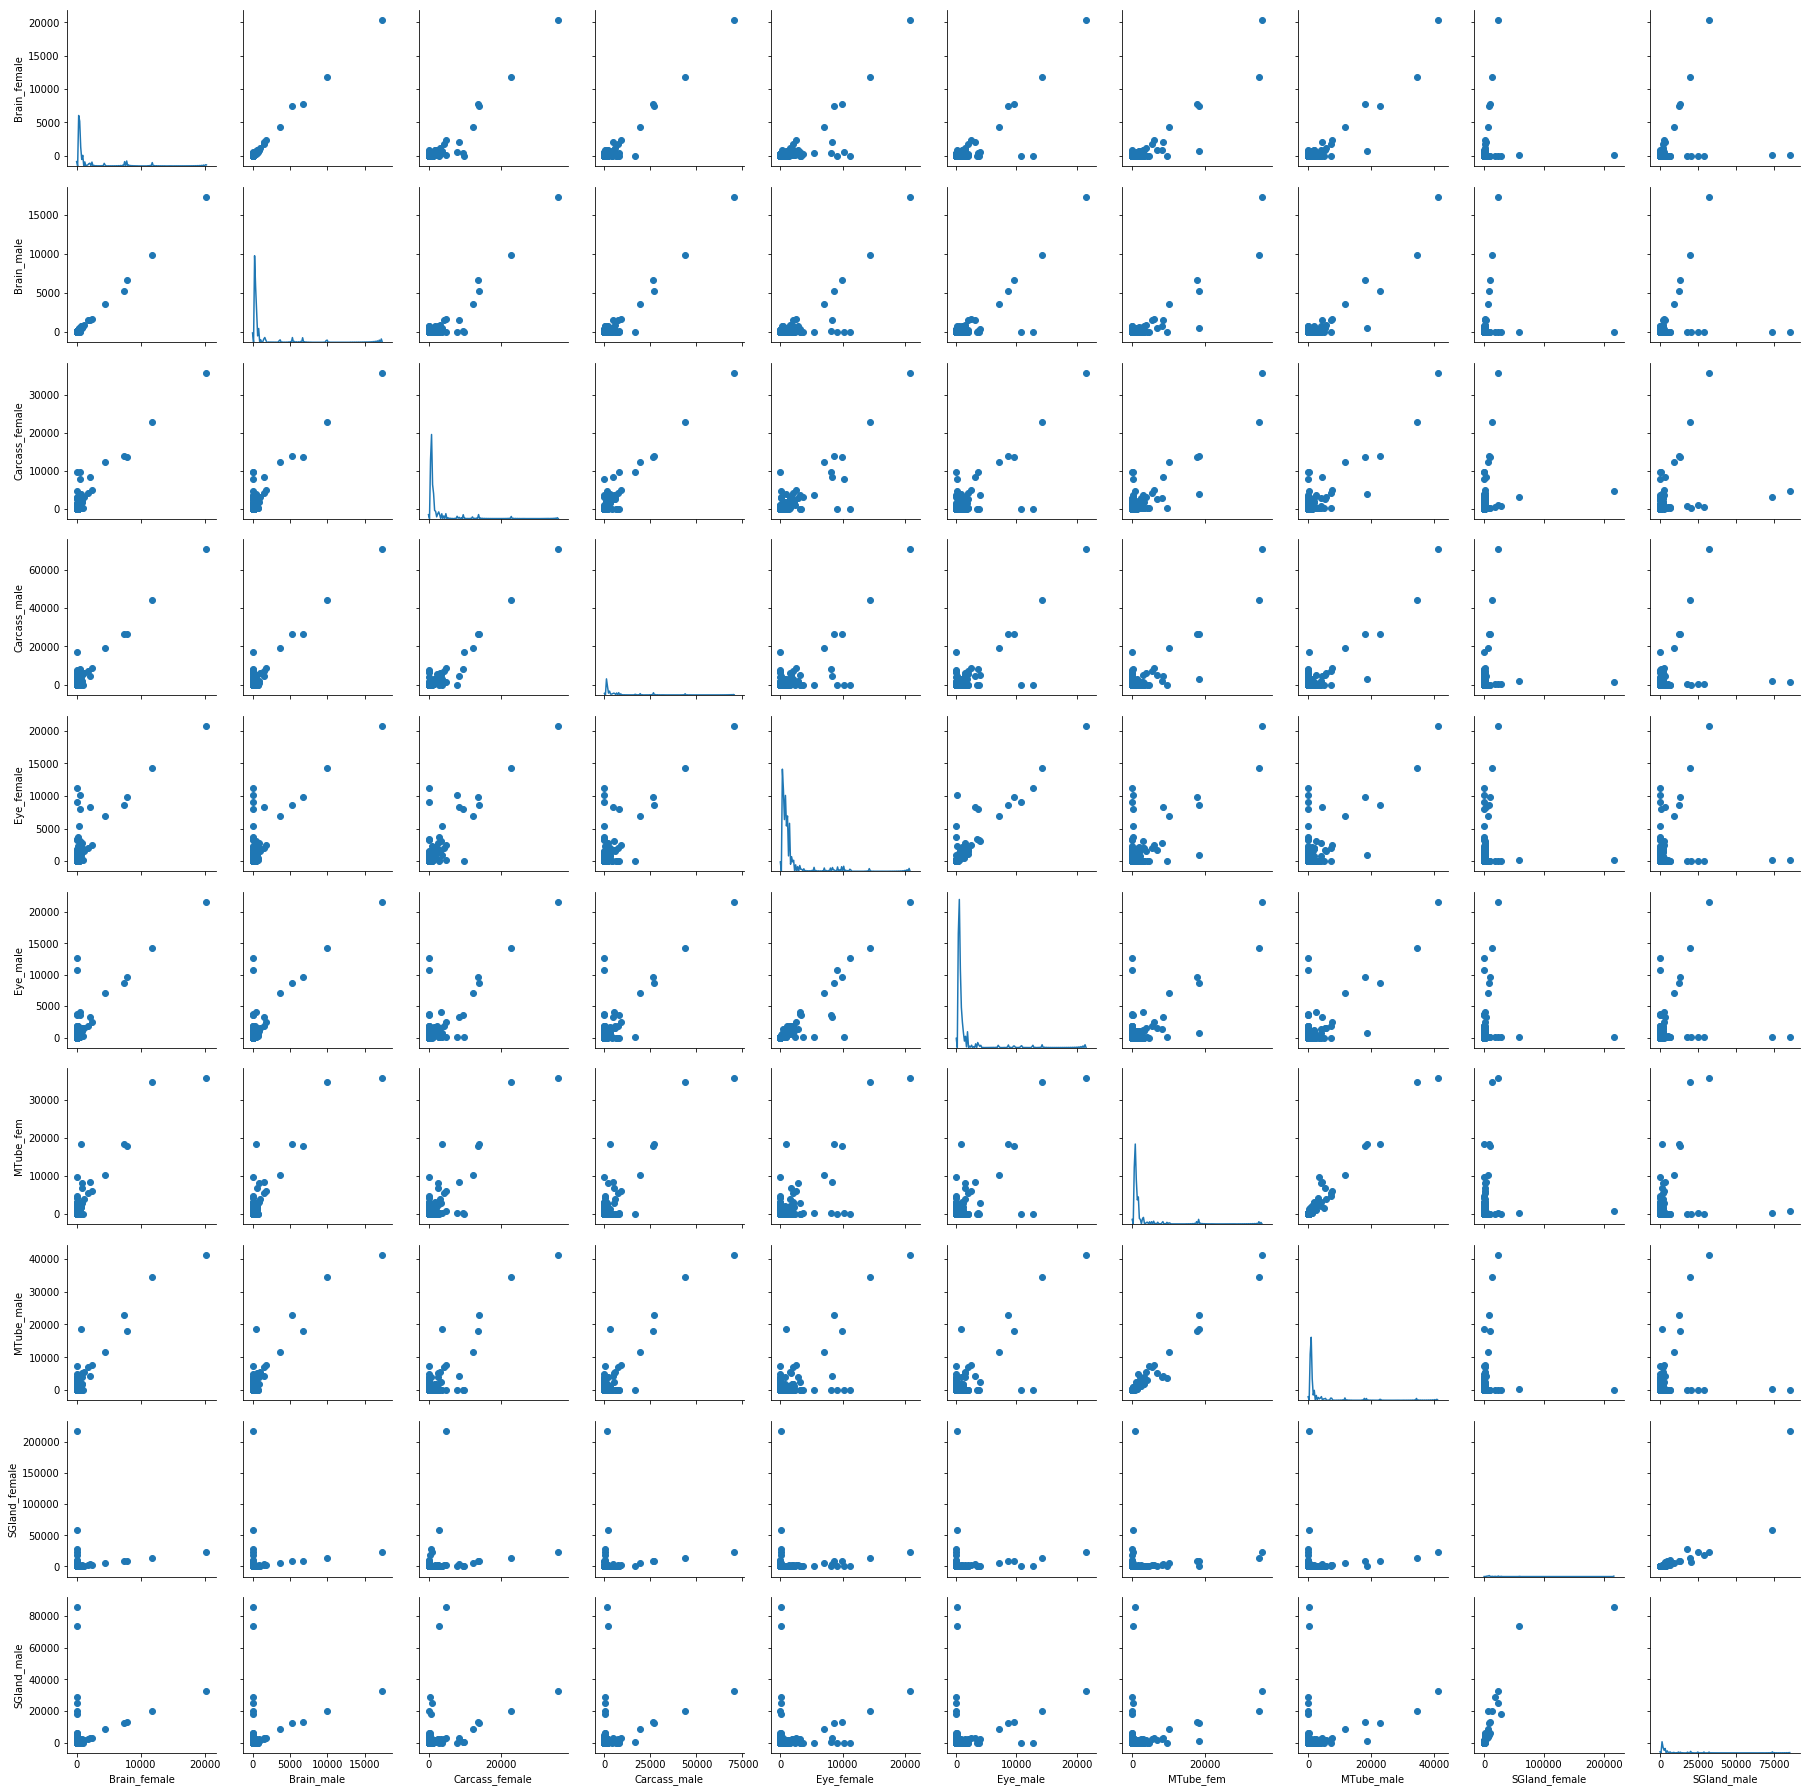

In [21]:
pair_grid = sns.PairGrid(data=adult_FPKM_df)
pair_grid.map_diag(sns.kdeplot)
pair_grid.map_offdiag(plt.scatter)

These plots show some very interesting insights.

-First, lets look at the diagonal plots - the kernel density estimate or kde plot. It shows that for most features the majority of the FPKM values is close to zero. That is also reflected in in the scatter plots, as there is a higher density of dots near zero for almost all features. This is also expected as we saw that 25% of the genes have FPKM near zero (see .describe() above).

-Looking at the scattter plots it looks like several of the features have a monotonic relationship for a given tissue between male and female. Some exaples are: brain female vs. brain male, Carcass female vs. carcass male, and MTube female vs Mtube male (Malpighian Tubules). This indicates that genes are express equally between male and female in those tissues.

-Interesting trends can be seen when comparing between tissues. For example Eye female vs SGland female shows a non-monotonic relationship. In fact it looks like the genes highly express in SGland female are expressed at low levels in Eye female and vice-versa.

-This is starting to get at the original quesiton I wanted to answer with this analysis and it indicates that depending on the tissue we are loking at expression can be the same for both male and female.

-Lets try to get a more quantitative anwer by looking at a correlation between the data.

-Since the average of each column doesn't really mean anything, I would use a non-parametric correlation.

In [22]:
kendall_corr = adult_FPKM_df.corr(method='kendall')
kendall_corr

,Brain_female,Brain_male,Carcass_female,Carcass_male,Eye_female,Eye_male,MTube_fem,MTube_male,SGland_female,SGland_male
Brain_female,1.000000,0.944802,0.584825,0.523256,0.697995,0.707176,0.550409,0.483445,0.607662,0.590044
Brain_male,0.944802,1.000000,0.564270,0.508779,0.672119,0.688099,0.540645,0.480373,0.595737,0.576640
Carcass_female,0.584825,0.564270,1.000000,0.764817,0.750679,0.702452,0.683014,0.581847,0.742350,0.740241
Carcass_male,0.523256,0.508779,0.764817,1.000000,0.657017,0.646834,0.598696,0.653951,0.607704,0.745622
Eye_female,0.697995,0.672119,0.750679,0.657017,1.000000,0.913180,0.616746,0.529731,0.684730,0.694603
Eye_male,0.707176,0.688099,0.702452,0.646834,0.913180,1.000000,0.597372,0.527281,0.657369,0.685973
MTube_fem,0.550409,0.540645,0.683014,0.598696,0.616746,0.597372,1.000000,0.821739,0.703975,0.685684
MTube_male,0.483445,0.480373,0.581847,0.653951,0.529731,0.527281,0.821739,1.000000,0.604536,0.670276
SGland_female,0.607662,0.595737,0.742350,0.607704,0.684730,0.657369,0.703975,0.604536,1.000000,0.800582
SGland_male,0.590044,0.576640,0.740241,0.745622,0.694603,0.685973,0.685684,0.670276,0.800582,1.000000


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <a list of 10 Text xticklabel objects>)

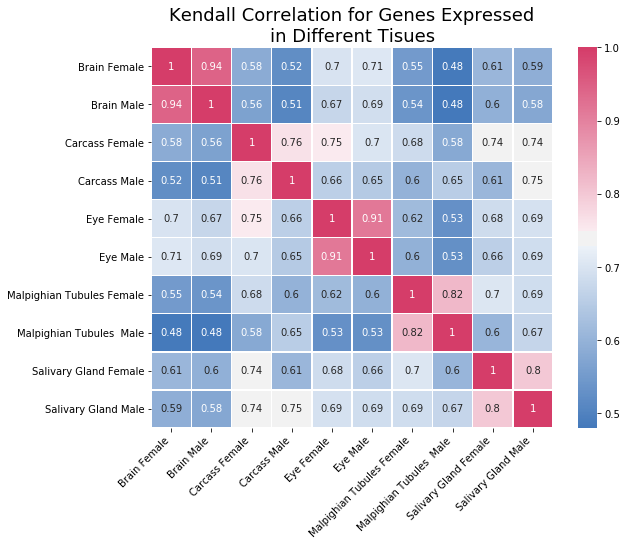

In [23]:
plt.figure(figsize=(9,7))
cmap = sns.diverging_palette(250, 0, as_cmap=True)

#Since this is a correlation matrix index and column names are the same and so are x and y tick labels.
ticklabels = ['Brain Female', 'Brain Male', 'Carcass Female', 'Carcass Male','Eye Female', 'Eye Male',
             'Malpighian Tubules Female', 'Malpighian Tubules  Male', 'Salivary Gland Female',
              'Salivary Gland Male']

sns.heatmap(data=kendall_corr, annot=True, fmt='0.2g', linewidth=0.5, linecolor='w', cmap=cmap,
            xticklabels=ticklabels, yticklabels=ticklabels)
plt.title('Kendall Correlation for Genes Expressed\nin Different Tisues', fontsize=18)
plt.xticks(rotation=45, ha='right')

-Lets talk about some of the take aways of these data. 
These data supports the idea that there is no big difference between female v. male gene expression for the same tissue as the correlation is at least 0.75 and sometimes as high as 0.94.

On the other hand, these data provides evidence supporting big differences between gene expression for different tissues. For example it shows big differences between male malpighian tubules and brain a the correlation is 0.48. Another good example is Eye from females v. malpighian tubules and carcas v. brain both male.

In conclusion, when doing experiments using tissues from flies one can use male or female if doing experiments in the same tissue and results can be extrapolated.

Before concluding this analysis, lets tackle the question of which are the highest expressing genes for each tissues.

In [4]:
#lets iterate over adult_FPKM_df to obatin highest expressing genes IDs and how much FPKM for each tissue.
#Store the values in the following list.
largest_FPKM_df = []

for i, column in adult_FPKM_df.iloc[:,1:].iteritems() :
    #get highest expressing genes for each tissue
    largest_df = adult_FPKM_df.nlargest(10,i)
    #append annotation symbol and FPKM for highest express genes
    largest_FPKM_df.append(largest_df[['Annotation Symbol', i]])

#concatenate all dataframe inside the list by column
largest_FPKM_df = pd.concat(largest_FPKM_df, axis=1)
largest_FPKM_df.head()

,Annotation Symbol,Brain_female,Annotation Symbol,Brain_male,Annotation Symbol,Carcass_female,Annotation Symbol,Carcass_male,Annotation Symbol,Eye_female,Annotation Symbol,Eye_male,Annotation Symbol,MTube_fem,Annotation Symbol,MTube_male,Annotation Symbol,SGland_female,Annotation Symbol,SGland_male
204,CG34074,11846.0,CG34074,9904.0,CG34074,22896.0,CG34074,43931.0,CG34074,14289.0,CG34074,14210.0,CG34074,34798.0,CG34074,34432.0,CG34074,13161.0,CG34074,19935.0
279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CG9470,18324.0,CG9470,18556.0,NaN,NaN,NaN,NaN
506,CG34092,1837.0,CG34092,1554.0,NaN,NaN,CG34092,7397.0,NaN,NaN,NaN,NaN,NaN,NaN,CG34092,7166.0,NaN,NaN,NaN,NaN
897,NaN,NaN,NaN,NaN,CG11129,7888.0,NaN,NaN,CG11129,10141.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CG45080,216994.0,CG45080,85494.0


-A quick glance at this data frame shows that not all the highest exressed genes are the same. This is reflected as a lot of empty values of NaN.

-This answers one important question. Genes express at a higer level in one tissue are not necessarily the same in other tissues.
 
-This is kind of expected as each tissue have different 'needs' and so it would regulate the expression of genes according to its needs.

-Lets modify the dataframe by dropping the NaN values.

In [5]:
largest_FPKM_df = largest_FPKM_df.apply(lambda x: pd.Series(x.dropna().values))
largest_FPKM_df

,Annotation Symbol,Brain_female,Annotation Symbol,Brain_male,Annotation Symbol,Carcass_female,Annotation Symbol,Carcass_male,Annotation Symbol,Eye_female,Annotation Symbol,Eye_male,Annotation Symbol,MTube_fem,Annotation Symbol,MTube_male,Annotation Symbol,SGland_female,Annotation Symbol,SGland_male
0,CG34074,11846.0,CG34074,9904.0,CG34074,22896.0,CG34074,43931.0,CG34074,14289.0,CG34074,14210.0,CG34074,34798.0,CG34074,34432.0,CG34074,13161.0,CG34074,19935.0
1,CG34092,1837.0,CG34092,1554.0,CG11129,7888.0,CG34092,7397.0,CG11129,10141.0,CG3481,4016.0,CG9470,18324.0,CG9470,18556.0,CG45080,216994.0,CG45080,85494.0
2,CG30425,2032.0,CG30425,1573.0,CG30425,8302.0,CG34067,70499.0,CG5711,9151.0,CG5711,10787.0,CG30425,8515.0,CG34092,7166.0,CG34212,59031.0,CG34212,73983.0
3,CG34067,20269.0,CG34067,17339.0,CG34067,35825.0,CG34073,19418.0,CG30425,8347.0,CG34067,21552.0,CG34067,35743.0,CG34067,41181.0,CG34067,23023.0,CG34067,32450.0
4,CG34073,4363.0,CG34073,3627.0,CG34073,12213.0,CG34090,26688.0,CG34067,20779.0,CG34073,7020.0,CG34073,10261.0,CG34073,11670.0,CG33109,28457.0,CG33109,18078.0
5,CG8369,930.0,CG3997,813.0,CG34090,13848.0,CG3972,16868.0,CG34073,6991.0,CG4899,3766.0,CG3997,8271.0,CG34090,22861.0,CG34090,8747.0,CG34090,12244.0
6,CG34090,7471.0,CG34090,5308.0,CG3972,9702.0,CG34085,9029.0,CG34090,8571.0,CG34090,8601.0,CG34076,6941.0,CG7874,7332.0,CG9538,23979.0,CG9538,25013.0
7,CG34085,2369.0,CG34085,1734.0,CG34085,4806.0,CG11051,8083.0,CG11051,8069.0,CG11051,3622.0,CG34090,18328.0,CG34085,7565.0,CG43679,18229.0,CG13947,20189.0
8,CG34083,1218.0,CG34083,976.0,CG11051,9592.0,CG42478,7759.0,CG5962,11204.0,CG5962,12669.0,CG34072,9665.0,CG34083,5526.0,CG43680,9772.0,CG43679,28836.0
9,CG34069,7827.0,CG34069,6708.0,CG34069,13740.0,CG34069,26514.0,CG34069,9843.0,CG34069,9584.0,CG34069,17825.0,CG34069,17905.0,CG34069,9071.0,CG34069,13225.0


Also, several columns have the same name 'Annotation Symbol' lets  differentiate each of them by addding the tissue that annotation symbol represents.

In [6]:
largest_FPKM_df.columns

Index(['Annotation Symbol', 'Brain_female', 'Annotation Symbol', 'Brain_male',
       'Annotation Symbol', 'Carcass_female', 'Annotation Symbol',
       'Carcass_male', 'Annotation Symbol', 'Eye_female', 'Annotation Symbol',
       'Eye_male', 'Annotation Symbol', 'MTube_fem', 'Annotation Symbol',
       'MTube_male', 'Annotation Symbol', 'SGland_female', 'Annotation Symbol',
       'SGland_male'],
      dtype='object')

In [7]:
cols = ['AS_Brain_female', 'Brain_female', 'AS_Brain_male', 'Brain_male','AS_Carcass_female',
        'Carcass_female','AS_Carcass_male','Carcass_male', 'AS_Eye_female', 'Eye_female',
        'AS_Eye_male','Eye_male', 'AS_MTube_fem','MTube_fem', 'AS_MTube_male','MTube_male',
        'AS_SGland_female', 'SGland_female', 'AS_SGland_male','SGland_male']

largest_FPKM_df.columns = cols
largest_FPKM_df

,AS_Brain_female,Brain_female,AS_Brain_male,Brain_male,AS_Carcass_female,Carcass_female,AS_Carcass_male,Carcass_male,AS_Eye_female,Eye_female,AS_Eye_male,Eye_male,AS_MTube_fem,MTube_fem,AS_MTube_male,MTube_male,AS_SGland_female,SGland_female,AS_SGland_male,SGland_male
0,CG34074,11846.0,CG34074,9904.0,CG34074,22896.0,CG34074,43931.0,CG34074,14289.0,CG34074,14210.0,CG34074,34798.0,CG34074,34432.0,CG34074,13161.0,CG34074,19935.0
1,CG34092,1837.0,CG34092,1554.0,CG11129,7888.0,CG34092,7397.0,CG11129,10141.0,CG3481,4016.0,CG9470,18324.0,CG9470,18556.0,CG45080,216994.0,CG45080,85494.0
2,CG30425,2032.0,CG30425,1573.0,CG30425,8302.0,CG34067,70499.0,CG5711,9151.0,CG5711,10787.0,CG30425,8515.0,CG34092,7166.0,CG34212,59031.0,CG34212,73983.0
3,CG34067,20269.0,CG34067,17339.0,CG34067,35825.0,CG34073,19418.0,CG30425,8347.0,CG34067,21552.0,CG34067,35743.0,CG34067,41181.0,CG34067,23023.0,CG34067,32450.0
4,CG34073,4363.0,CG34073,3627.0,CG34073,12213.0,CG34090,26688.0,CG34067,20779.0,CG34073,7020.0,CG34073,10261.0,CG34073,11670.0,CG33109,28457.0,CG33109,18078.0
5,CG8369,930.0,CG3997,813.0,CG34090,13848.0,CG3972,16868.0,CG34073,6991.0,CG4899,3766.0,CG3997,8271.0,CG34090,22861.0,CG34090,8747.0,CG34090,12244.0
6,CG34090,7471.0,CG34090,5308.0,CG3972,9702.0,CG34085,9029.0,CG34090,8571.0,CG34090,8601.0,CG34076,6941.0,CG7874,7332.0,CG9538,23979.0,CG9538,25013.0
7,CG34085,2369.0,CG34085,1734.0,CG34085,4806.0,CG11051,8083.0,CG11051,8069.0,CG11051,3622.0,CG34090,18328.0,CG34085,7565.0,CG43679,18229.0,CG13947,20189.0
8,CG34083,1218.0,CG34083,976.0,CG11051,9592.0,CG42478,7759.0,CG5962,11204.0,CG5962,12669.0,CG34072,9665.0,CG34083,5526.0,CG43680,9772.0,CG43679,28836.0
9,CG34069,7827.0,CG34069,6708.0,CG34069,13740.0,CG34069,26514.0,CG34069,9843.0,CG34069,9584.0,CG34069,17825.0,CG34069,17905.0,CG34069,9071.0,CG34069,13225.0


In [8]:
#Lets reshape the dataframe so that all genes measured expression is in one column and aso adding ahother column
#that tells me from which tissue is that data. A way to do this is by melting the data with pd.melt

melted_largest_df = pd.melt(largest_FPKM_df, id_vars=['AS_Brain_female','AS_Brain_male',
                                                      'AS_Carcass_female','AS_Carcass_male',
                                                      'AS_Eye_female', 'AS_Eye_male','AS_MTube_fem',
                                                      'AS_MTube_male','AS_SGland_female',
                                                      'AS_SGland_male'])
melted_largest_df.head(15)

,AS_Brain_female,AS_Brain_male,AS_Carcass_female,AS_Carcass_male,AS_Eye_female,AS_Eye_male,AS_MTube_fem,AS_MTube_male,AS_SGland_female,AS_SGland_male,variable,value
0,CG34074,CG34074,CG34074,CG34074,CG34074,CG34074,CG34074,CG34074,CG34074,CG34074,Brain_female,11846.0
1,CG34092,CG34092,CG11129,CG34092,CG11129,CG3481,CG9470,CG9470,CG45080,CG45080,Brain_female,1837.0
2,CG30425,CG30425,CG30425,CG34067,CG5711,CG5711,CG30425,CG34092,CG34212,CG34212,Brain_female,2032.0
3,CG34067,CG34067,CG34067,CG34073,CG30425,CG34067,CG34067,CG34067,CG34067,CG34067,Brain_female,20269.0
4,CG34073,CG34073,CG34073,CG34090,CG34067,CG34073,CG34073,CG34073,CG33109,CG33109,Brain_female,4363.0
5,CG8369,CG3997,CG34090,CG3972,CG34073,CG4899,CG3997,CG34090,CG34090,CG34090,Brain_female,930.0
6,CG34090,CG34090,CG3972,CG34085,CG34090,CG34090,CG34076,CG7874,CG9538,CG9538,Brain_female,7471.0
7,CG34085,CG34085,CG34085,CG11051,CG11051,CG11051,CG34090,CG34085,CG43679,CG13947,Brain_female,2369.0
8,CG34083,CG34083,CG11051,CG42478,CG5962,CG5962,CG34072,CG34083,CG43680,CG43679,Brain_female,1218.0
9,CG34069,CG34069,CG34069,CG34069,CG34069,CG34069,CG34069,CG34069,CG34069,CG34069,Brain_female,7827.0


This is actually not what I need. The resultant dataframe doesn't represent the actual data as each column is just repeated 10 times. On the other hand, the column 'variable' will be useful for another approach to reshape the data. So lets keep the object.

In [9]:
#Different approach
#Make a new dataframe with genes expression only of FPKM and then concatenate it to get a single column.
FPKM_df_largest = largest_FPKM_df.drop(['AS_Brain_female','AS_Brain_male','AS_Carcass_female',
                                        'AS_Carcass_male','AS_Eye_female', 'AS_Eye_male',
                                        'AS_MTube_fem', 'AS_MTube_male','AS_SGland_female',
                                        'AS_SGland_male'], axis=1)

FPKM_df_largest = pd.concat([FPKM_df_largest[col] for col in FPKM_df_largest]).reset_index(drop=True)

#Now, lets make a new dataframe with annotation symbol only and then concatenate it to get a single column.
AS_df_largest = largest_FPKM_df.drop(['Brain_female','Brain_male','Carcass_female','Carcass_male','Eye_female',
                                      'Eye_male','MTube_fem', 'MTube_male','SGland_female', 'SGland_male'], axis=1)
AS_df_largest = pd.concat([AS_df_largest[col] for col in AS_df_largest]).reset_index(drop=True)

#Finally, lets build a new dataframe that will have the date from the precious 2 dataframes and the variable 
#column from the melted df. This column will serve as a tissue and female or male ID
synthesized_largest_df = pd.DataFrame(data={'AS':AS_df_largest,'Tissue':melted_largest_df['variable'],'FPKM':FPKM_df_largest})

synthesized_largest_df.head(15)

,AS,Tissue,FPKM
0,CG34074,Brain_female,11846.0
1,CG34092,Brain_female,1837.0
2,CG30425,Brain_female,2032.0
3,CG34067,Brain_female,20269.0
4,CG34073,Brain_female,4363.0
5,CG8369,Brain_female,930.0
6,CG34090,Brain_female,7471.0
7,CG34085,Brain_female,2369.0
8,CG34083,Brain_female,1218.0
9,CG34069,Brain_female,7827.0


Lets make a nice and interactive illustration using these data and bokeh.

In [10]:
from bokeh.plotting import figure, output_file
from bokeh.models import ColumnDataSource, CategoricalColorMapper
from bokeh.io import output_notebook, show, save

output_notebook() #show plot inline

Loading BokehJS ...

In [11]:
source=ColumnDataSource(synthesized_largest_df)

TOOLTIPS = [('Tissue','@Tissue'), ('Annotation Symbol','@AS'), ('FPKM','@FPKM')]

plot = figure(width=950, height=400, x_range=list(set(synthesized_largest_df.AS)),
              y_range=(-10000,250000),tools='pan, box_zoom, reset, hover',
              title='Genes Expressed at Highest Levels in Different Tissues in Females and Males Flies', 
              x_axis_label='Annotation Symbol', y_axis_label='FPKM', tooltips=TOOLTIPS)

plot.left[0].formatter.use_scientific = False #Turn off scientific notation in y axis

mapper = CategoricalColorMapper(factors=synthesized_largest_df.Tissue.unique(),
                               palette=['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c',
                                        '#fdbf6f','#ff7f00','#cab2d6','#6a3d9a'])

plot.circle(x='AS', y='FPKM', source=source, alpha=0.6, size=10,
           color={'field':'Tissue', 'transform':mapper})

plot.xgrid.grid_line_color = None
plot.ygrid.grid_line_color = None

plot.xaxis.major_label_orientation = 45

show(plot)